In [1]:
import pickle
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.api as sm
import statsmodels.tsa as tsa
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
import joblib
import pdb

In [2]:
def read_pickle(path):
    
    input_file = open(path,'rb')
    variable = pickle.load(input_file)
    input_file.close()
    return(variable)

def downsample(df, downsample_step = 10):
    
    # Downsample
    df['downsample'] = df['time_period'] % downsample_step
    df = df[df['downsample'] == 0]
    
    return(df)

In [3]:
# Read in data
data = read_pickle('../data/watch/processed_data/train_df.pkl')

# Downsample, we don't need that many observations
data = downsample(data, downsample_step = 5)
len(data)

484378

In [4]:
x = data.drop('is_exercise', axis = 1)
y = data['is_exercise']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [78]:
x_train = x_train.set_index(['subject_id', 'activity_class', 'timestamp', 'time_period'])
x_train_index = x_train.index
x_train = x_train.reset_index()
x_train_colnames = x_train.columns

In [5]:
def save_model(model, path):
    joblib.dump(model, path)
    print('Saved Model: ', path)
    
def load_model(path):
    model = joblib.load(path)
    return(model)

In [24]:
#Plot ROC Curve
def roc_plot(model, x, y):
    
    y_scores = model.predict_proba(x)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    
    plt.plot(fpr, tpr, linewidth = 2, label = None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    #plt.show()
    
    #cv_scores = cross_val_score(model, x, y, scoring='roc_auc', cv=10)
    #cv_scores_mean = np.mean(cv_scores)
    
    # Optimal threshold
    #opt_index = np.argmax(tpr/(fpr+0.01))
    #threshold = thresholds[opt_index]
    
    return threshold

    
#Plot basic diagnostics
def classification_diagnostics(model, x, y, standardize = True, classifier = True):
    
    fig, axs = plt.subplots(nrows = 1, ncols=2, figsize = (15,4))
    
    if classifier == True:
        
        y_hat = model.predict_proba(x)[:, 1]
        residuals = y - y_hat
        std_error = math.sqrt(np.var(residuals))
        std_residuals = residuals/std_error
        
    else:
        
        y_hat = model.predict(x)
        residuals = y_hat - y
        std_error = math.sqrt(np.var(residuals))
        std_residuals = residuals/std_error
        
    #Residual vs Fitted Plot
    sns.regplot(y_hat, 
                std_residuals, 
                #lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 1},
                ax = axs[0])
    
    #Histogram of residuals
    sns.distplot(std_residuals, 
                hist=True,
                ax = axs[1])
    
    #Labels
    axs[0].set(xlabel="Fitted Values", 
                ylabel="Pearson's Standardized Residuals", 
                title = 'Residual vs Fitted')
    
    axs[1].set(xlabel="Fitted Values", 
                ylabel="Frequency", 
                title = "Residuals Histogram")

In [7]:
class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, select_features):
        self.select_features = select_features
    
    def fit(self, x_df, y=None):
        return self
    
    def transform(self, x_df, y=None):
        select_features = self.select_features
        x_df = x_df[select_features]
        return(x_df)

    
class ContinuousFeatureEngineering(BaseEstimator, TransformerMixin):
    
    # Initiate class
    def __init__(self, window):
        self.window = window
        return None
        
    # We don't need to fit anything, so leave this as is
    def fit(self, df, y=None):
        return self
    
    # Perform our feature transformations
    def transform(self, df, y=None):
        
        x_df = df.copy(deep = True)
        
        col_names = x_df.columns
        
        # Time-Series transformations
        for col in col_names:
            
            # Box-Cox estimation
            x_df[col] = x_df[col] - min(x_df[col]) + 0.0001
            y, fitted_lambda = scipy.stats.boxcox(x_df[col],lmbda = None)
        
            # First difference, make first element nan, loss from differencing
            y = np.append([np.nan], np.diff(y, n=1))
            x_df[col] = y
        
        # Add volatility columns
        for col in col_names:
            x_df[col + '_vol'] = x_df[col].rolling(self.window).std()
        
        # Add moving average columns
        for col in col_names:
            x_df[col + '_ma'] = x_df[col].rolling(self.window).mean()
        
        # Fill nan values with mean
        x_df = x_df.fillna(x_df.mean())
        
        # Standardize data
        standard_scaler = preprocessing.StandardScaler()
        x_df = standard_scaler.fit_transform(x_df)
        
        return x_df
    
    
class OutlierRemoval(BaseEstimator, TransformerMixin):
    
    # Initiate class
    def __init__(self, window):
        self.window = window
        return None
        
    # We don't need to fit anything, so leave this as is
    def fit(self, x, y=None):
        return self
    
    # Perform our feature transformations
    def transform(self, x, y, std_residuals):
        
        # Convert to array
        std_residuals = np.array(std_residuals)
        y = np.array(y)
        
        # standardized 
        outliers = np.where(std_residuals < 2.5)
        
        return outliers

In [103]:
abs_std_residuals = abs(np.array(std_residuals))

29480     0.0
7380      0.0
46807     1.0
26690     0.0
35026     0.0
         ... 
6815      1.0
42204     0.0
23510     0.0
118838    0.0
64379     0.0
Name: is_exercise, Length: 387502, dtype: float64

In [109]:
np.array(y_train)[np.where(abs_std_residuals >2.5)]

array([1., 1., 1., ..., 1., 0., 0.])

In [55]:
# ----Feature Pipeline ----#
num_attributes = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
window = 100

numerical_pipeline = Pipeline([

    ('FeatureSelector', FeatureSelector(num_attributes)),
    ('FeatureEngineering', ContinuousFeatureEngineering(window))
])

In [56]:
check_pca = numerical_pipeline.fit_transform(x_train)

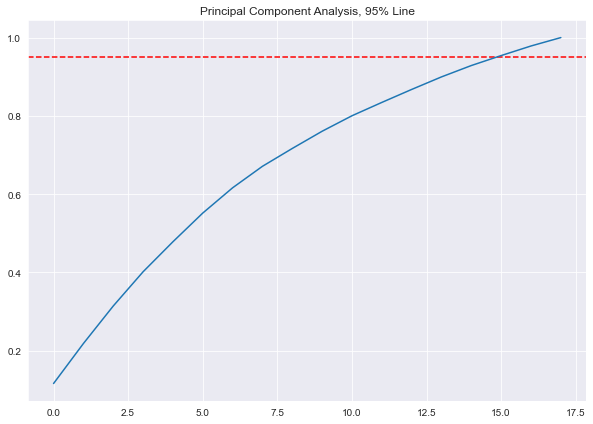

In [57]:
#Hmm seems like the features are quite different, let's not apply PCA for now
pca = PCA() #use all components for now
x_pca = pca.fit_transform(check_pca)
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Principal Component Analysis, 95% Line')
ax.axhline(0.95, ls='--', color = 'red')
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [58]:
feature_pipeline = FeatureUnion([
        ('numerical_pipeline', numerical_pipeline)
    ])

## Test some algorithms

In [59]:
processed_x_train = feature_pipeline.fit_transform(x_train)
proccessed_x_test = feature_pipeline.fit_transform(x_test)

Logistic Regression

In [60]:
log_model = LogisticRegression()
log_model.fit(processed_x_train, y_train)
scores = cross_val_score(log_model, processed_x_train, y_train,
                        scoring = "roc_auc", cv = 10)
print('CV AUC Scores: ', scores)
print('Mean CV AUC Scores: ', np.mean(scores))

CV AUC Scores:  [0.68696169 0.67998073 0.67905707 0.68852554 0.68498127 0.6840644
 0.69067719 0.68879183 0.68961226 0.69094398]
Mean CV AUC Scores:  0.6863595961239267


In [61]:
predict = log_model.predict(proccessed_x_test)
roc_auc_score(predict, y_test)

0.6904624919929266

CART Classifier

In [62]:
cart_model = DecisionTreeClassifier(min_samples_leaf = 30) #blanket default, to avoid 1 observation per leaf
cart_model.fit(processed_x_train, y_train)

scores = cross_val_score(cart_model, processed_x_train, y_train,
                        scoring = "roc_auc", cv = 10)
print('CV AUC Scores: ', scores)
print('Mean CV AUC Scores: ', np.mean(scores))

CV AUC Scores:  [0.83021139 0.83436956 0.83237822 0.83619341 0.83457468 0.83617683
 0.83856373 0.83430096 0.83152982 0.8340792 ]
Mean CV AUC Scores:  0.8342377802966757


In [63]:
predict = cart_model.predict(proccessed_x_test)
roc_auc_score(predict, y_test)

0.7545888692050081

In [126]:
rand_forest_model = RandomForestClassifier(min_samples_leaf = 30,verbose=3,n_jobs=-1, warm_start=True)
rand_forest_model.fit(processed_x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100building tree 5 of 100building tree 6 of 100

building tree 7 of 100building tree 8 of 100


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100building tree 16 of 100

building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100building tree 21 of 100

building tree 22 of 100
building tree 23 of 100building tree 24 of 100



[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.6s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100building tree 35 of 100

building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.4s finished


RandomForestClassifier(min_samples_leaf=30, n_jobs=-1, verbose=3,
                       warm_start=True)

In [128]:
scores = cross_val_score(rand_forest_model, processed_x_train, y_train,
                        scoring = "roc_auc", cv = 10)
print('CV AUC Scores: ', scores)
print('Mean CV AUC Scores: ', np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]:

CV AUC Scores:  [0.88033563 0.87970733 0.87758277 0.88125192 0.8815829  0.88153785
 0.88394928 0.88147938 0.87774837 0.87925056]
Mean CV AUC Scores:  0.8804425991465161


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [254]:
#save_model(rand_forest_model, path = '../data/watch/models/random_forest_model.pkl')

Saved Model:  ../data/watch/models/random_forest_model.pkl


In [13]:
rand_forest_model = load_model(path = '../data/watch/models/random_forest_model.pkl')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


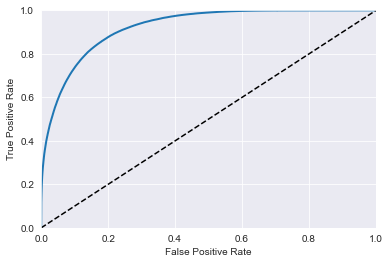

In [14]:
fpr, tpr, thresholds = roc_plot(rand_forest_model, processed_x_train, y_train)

In [16]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [19]:
y_hat = rand_forest_model.predict_proba(processed_x_train)[:,1]
Find_Optimal_Cutoff(y_train, y_hat)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


[0.3093594665949352]

[]

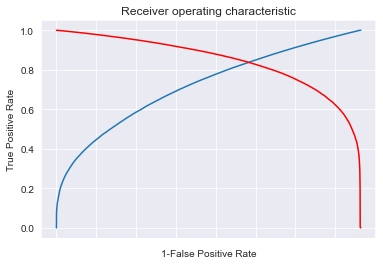

In [15]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [20]:
#This is on the unseen test set, we can do cross val as well and that'll be about 5 mins.
use_threshold = 0.31
predict = rand_forest_model.predict_proba(proccessed_x_test)
predict = [1 if x >= use_threshold else 0 for x in predict[:, 1]]
roc_auc_score(predict, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


0.7607697612362203

In [21]:
CM = confusion_matrix(y_test, predict)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
precision =  TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = 2 * ((precision * recall) / (precision + recall))

print('TN: ', TN, ' | FN: ', FN)
print('TP: ', TP, ' | FP: ', FP)
print('')
print('Precision: ', precision) # of the positive predictions, percentage that is correct
print('Recall: ',  recall) # of the actual positives, percentage that is correct
print('F1 Score: ', f1_score)

TN:  57344  | FN:  5922
TP:  20675  | FP:  12935

Precision:  0.6151443022909848
Recall:  0.7773433093957965
F1 Score:  0.6867972162705334


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


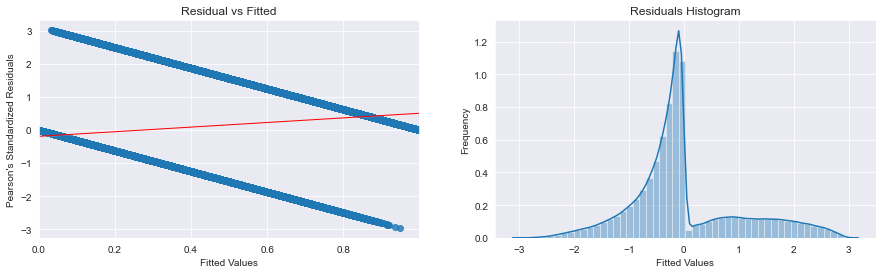

In [25]:
classification_diagnostics(rand_forest_model, processed_x_train, y_train, standardize = True, classifier = True)

In [73]:
#Check autocorrelation
y_hat = rand_forest_model.predict_proba(processed_x_train)[:,1]
residuals = y_train - y_hat
std_error = math.sqrt(np.var(residuals))
std_residuals = residuals/std_error

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


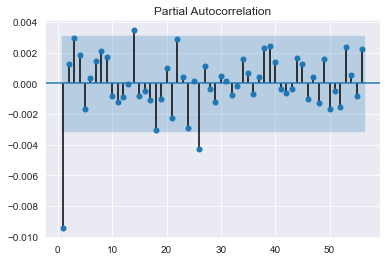

In [82]:
# No significant autocorrelations except for a few points
series = sm.graphics.tsa.plot_pacf(residual_df['is_exercise'], zero = False)

In [ ]:
# Outlier removal
outlier_removal()

Gradient Boosting Classifier

In [131]:
gboost_model = GradientBoostingClassifier(warm_start=True, min_samples_leaf = 30)
gboost_model.fit(processed_x_train, y_train)

GradientBoostingClassifier(min_samples_leaf=30, warm_start=True)

In [132]:
predict = gboost_model.predict(proccessed_x_test)
roc_auc_score(predict, y_test)

0.7953677696195304

### Neural Net

This is probably an overkill but we have to do it for fun